In [53]:
import numpy as np 
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from LSTM.PytorchLSTMTrain import LSTMModel
from Transformer.autoregressiveTrain import MotorTransformer 
from IPython.display import clear_output
import time
import torch.nn.functional as F


In [100]:
#useful functions 
def train(model,loader,test_loader,n_epochs,start_channel,end_channel,window,sched,filename):
    scheduler=np.arange(0,0.9,0.9/(n_epochs))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    history=[]
    for epoch in range(n_epochs):
        total_loss = 0.0
        for (X,) in loader:     # X: (batch, seq_len, input_dim)
            X = X.to(device)
            optimizer.zero_grad()
            seq_len=X.shape[1]
            hidden = None                   # LSTM hidden state
            losses = []
            #predict each future step autoregressively
            inp = X[:, :window,start_channel:end_channel]
            for t in range(window, seq_len):
                # Forward pass
                pred=model(inp)  # (batch,1,12)

                # Compute target delta
                target= X[:, t-window+1:t+1, :12]
                #target_delta = X[:, t-window+1:t+1, :12] - X[:, t-window:t, :12]
                #target_delta = target_delta.unsqueeze(1)  # (batch,1,12)
                losses.append(criterion(pred, target))

                # Reconstruct absolute motor positions
                motors = pred#inp[:, :, :12] + pred
                # Scheduled sampling
                if np.random.random() < scheduler[epoch] and sched:
                    if start_channel<12:
                        remainder = X[:, t-window+1:t+1, 12:end_channel]
                        inp = torch.cat([motors.detach(), remainder.to(device)], dim=2)
                    else: inp= X[:, t-window+1:t+1, start_channel:end_channel]
                else:
                    inp = X[:, t-window+1:t+1, start_channel:end_channel]


            loss = torch.stack(losses).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            #clear_output(wait=True)
            #print(f"Live Loss: {total_loss:.6f}")
        avg_loss = total_loss / len(loader)
        clear_output(wait=True)
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.6f} | Probability:"+str(scheduler[epoch]*sched))
        mse = check_unseen_loss(model, test_loader, window=window, device=device)
        model.train()
        print("Unseen prediction MSE:", mse)
        history.append([avg_loss, mse])
    #torch.save(model.state_dict(), filename+"_model")
    history=np.array(history)
    np.save(filename+"loss",history)
    return history

def check_unseen_loss(model, loader, window, device):
    model.eval()
    total_mse = 0.0
    count = 0
    with torch.no_grad():
        for (X,) in loader:   # X shape: (batch, time, features)
            X = X.to(device)
            T = X.shape[1]
            motors_dim = 12
            sensor_dim = X.shape[2] - motors_dim
            x = X[:,:window, :]
            #store predictions
            preds = []
            #predict from window to end
            for t in range(window, T-1):
                pred = model(x)  
                pred=pred[:,-1,:]
                preds.append(pred.cpu())   
                pred=pred.reshape(len(pred),1,motors_dim)          
                current_sensors = x[:,t-window+1:t, :]         
                next_sensors = X[:,t, motors_dim:].reshape(len(X),1,sensor_dim) 
                x=x[:,1:,:] #roll back
                new_entry=torch.cat([pred,next_sensors], dim=2)
                x = torch.cat([x,new_entry], dim=1)
            # convert predictions and truth to tensors
            preds = torch.stack(preds, dim=1)                   
            truth = X[:,window+1:,:motors_dim].cpu()         
            # compute MSE for this sequence
            mse = F.mse_loss(preds, truth)
            total_mse += mse.item()
            count += 1

    return total_mse / count


X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/X_sorted.npy")[0:100]
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)    # 20% test
train_size = dataset_size - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)
model = LSTMModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)


## Loss
Train a bunch of models normally and save the loss, then average and show 

In [101]:
X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/X_sorted.npy")
print(X.shape)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
WINDOW=15
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)    # 20% test
train_size = dataset_size - test_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
for trial in range(20):
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)
    INPUT_DIM=X_tensor.shape[2]
    OUTPUT_DIM=12
    model = LSTMModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)
    train(model,train_loader,test_loader,500,0,20,WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial))

for trial in range(20):
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_loader, batch_size=128, shuffle=True)
    test_loader  = DataLoader(test_loader,  batch_size=128, shuffle=False)
    INPUT_DIM=X_tensor.shape[2]
    OUTPUT_DIM=12
    model = MotorTransformer(input_dim=INPUT_DIM,output_dim=OUTPUT_DIM,T=WINDOW).to(device)
    train(model,train_dataset,test_loader,500,0,20,WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial))

Epoch 144 | Loss: 51.084591 | Probability:0.2574


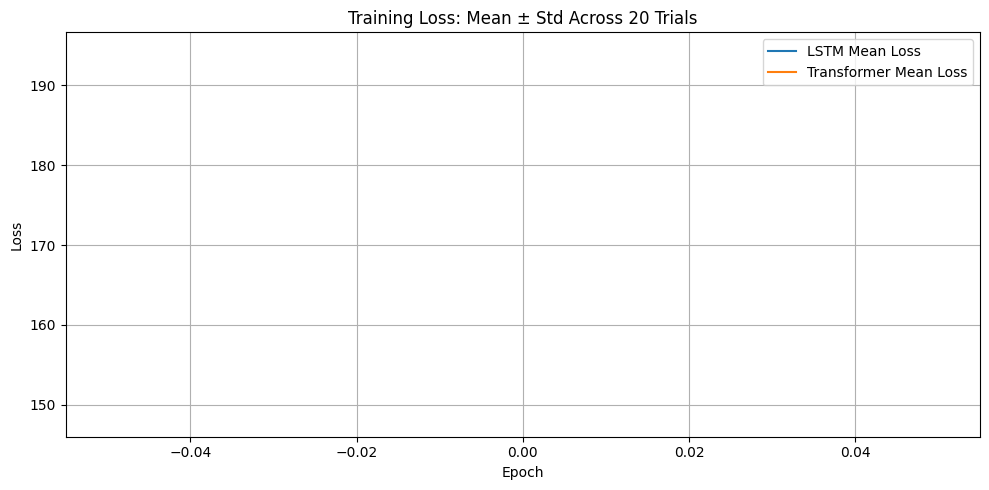

In [ ]:
LSTM_LOSS=[]
TRANS_LOSS=[]
for trial in range(20):
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial)+"loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial)+"loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_LOSS.append(loss_lstm)
    TRANS_LOSS.append(loss_trans)

LSTM_LOSS=np.array(LSTM_LOSS)
TRANS_LOSS=np.array(TRANS_LOSS)

lstm_mean = LSTM_LOSS.mean(axis=0)
lstm_std  = LSTM_LOSS.std(axis=0)
trans_mean = TRANS_LOSS.mean(axis=0)
trans_std  = TRANS_LOSS.std(axis=0)
epochs = np.arange(len(lstm_mean))
plt.figure(figsize=(10,5))
plt.plot(epochs, lstm_mean[0],c="r", label="LSTM Mean Loss")
plt.plot(epochs, lstm_mean[1],"--",c="r", label="LSTM Mean Loss Unseen")
plt.fill_between(epochs, lstm_mean[0] - lstm_std[0], lstm_mean[0] + lstm_std[0], alpha=0.2)
plt.plot(epochs, trans_mean[0],c="b", label="Transformer Mean Loss")
plt.plot(epochs, trans_mean[1],"--",c="b", label="Transformer Mean Loss Unseen")
plt.fill_between(epochs, trans_mean[0] - trans_std[0], trans_mean[0] + trans_std[0], alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss: Mean ± Std Across 20 Trials")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/plots/loss.pdf")
plt.show()


## Useful data
Train various models on different parts of the data 
- motors only
- all signals
- tactile vectors and friction only
Plot the data in a table 

In [ ]:
X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/X_sorted.npy")
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
WINDOW=15
config=[[0,12],[12,20]]
for trial in range(20):
    for i,conf in enumerate(config):
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=conf[1]-conf[0]
        OUTPUT_DIM=12
        model = LSTMModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)
        train(model,loader,500,conf[0],conf[1],WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/LSTMtrial_"+str(trial)+"_"+str(i))

for trial in range(20):
    for i,conf in enumerate(config):
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=conf[1]-conf[0]
        OUTPUT_DIM=12
        model = MotorTransformer(input_dim=INPUT_DIM,output_dim=OUTPUT_DIM,T=WINDOW).to(device)
        train(model,loader,500,conf[0],conf[1],WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/TRANStrial_"+str(trial)+"_"+str(i))

Epoch 01 | Loss: 275.414948 | Probability:0.0


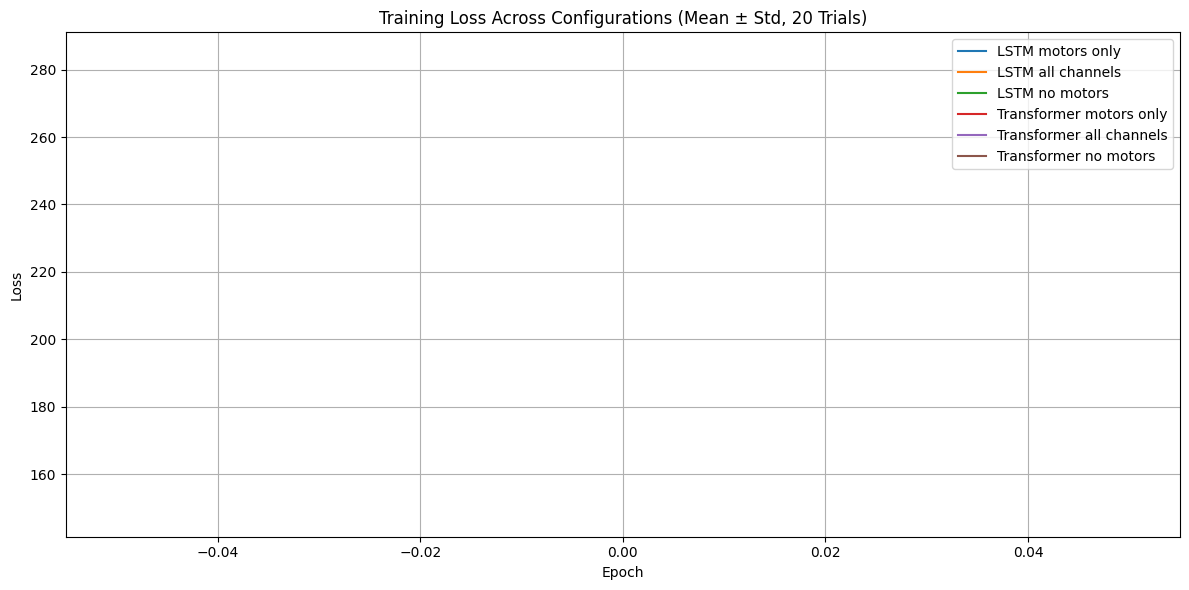

In [ ]:
LSTM_conf1=[]
LSTM_conf2=[]
LSTM_conf3=[]
TRANS_conf1=[]
TRANS_conf2=[]
TRANS_conf3=[]
#follow order of bullet points above
for trial in range(20):
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial)+"loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial)+"loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_conf2.append(loss_lstm)
    TRANS_conf2.append(loss_trans)
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/LSTMtrial_"+str(trial)+"_0loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/TRANStrial_"+str(trial)+"_0loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_conf1.append(loss_lstm)
    TRANS_conf1.append(loss_trans)
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/LSTMtrial_"+str(trial)+"_1loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/TRANStrial_"+str(trial)+"_1loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_conf3.append(loss_lstm)
    TRANS_conf3.append(loss_trans)

LSTM_conf1 = np.array(LSTM_conf1)
LSTM_conf2 = np.array(LSTM_conf2)
LSTM_conf3 = np.array(LSTM_conf3)

TRANS_conf1 = np.array(TRANS_conf1)
TRANS_conf2 = np.array(TRANS_conf2)
TRANS_conf3 = np.array(TRANS_conf3)
def compute_stats(arr):
    return arr.mean(axis=0), arr.std(axis=0)
lstm_mean1, lstm_std1 = compute_stats(LSTM_conf1)
lstm_mean2, lstm_std2 = compute_stats(LSTM_conf2)
lstm_mean3, lstm_std3 = compute_stats(LSTM_conf3)

trans_mean1, trans_std1 = compute_stats(TRANS_conf1)
trans_mean2, trans_std2 = compute_stats(TRANS_conf2)
trans_mean3, trans_std3 = compute_stats(TRANS_conf3)

# Plot all configs in one figure
epochs = np.arange(len(lstm_mean1))
plt.figure(figsize=(12,6))

# LSTM curves
plt.plot(epochs, lstm_mean1, label="LSTM motors only")
plt.fill_between(epochs, lstm_mean1 - lstm_std1, lstm_mean1 + lstm_std1, alpha=0.15)

plt.plot(epochs, lstm_mean2, label="LSTM all channels")
plt.fill_between(epochs, lstm_mean2 - lstm_std2, lstm_mean2 + lstm_std2, alpha=0.15)

plt.plot(epochs, lstm_mean3, label="LSTM no motors")
plt.fill_between(epochs, lstm_mean3 - lstm_std3, lstm_mean3 + lstm_std3, alpha=0.15)

# Transformer curves
plt.plot(epochs, trans_mean1, label="Transformer motors only")
plt.fill_between(epochs, trans_mean1 - trans_std1, trans_mean1 + trans_std1, alpha=0.15)

plt.plot(epochs, trans_mean2, label="Transformer all channels")
plt.fill_between(epochs, trans_mean2 - trans_std2, trans_mean2 + trans_std2, alpha=0.15)

plt.plot(epochs, trans_mean3, label="Transformer no motors")
plt.fill_between(epochs, trans_mean3 - trans_std3, trans_mean3 + trans_std3, alpha=0.15)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Across Configurations (Mean ± Std, 20 Trials)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/plots/loss_configs.pdf")
plt.show()

## Dataset size 
Look at model performance depending on dataset size and diversity of dataset

In [28]:
X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/X_sorted.npy")

WINDOW=15
config=[i for i in range(100,len(X),2000)]
for trial in range(20):
    for i,conf in enumerate(config):
        X_tensor = torch.tensor(X, dtype=torch.float32)[:100]
        dataset = TensorDataset(X_tensor)
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=X_tensor.shape[2]
        OUTPUT_DIM=12
        model = LSTMModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)
        train(model,loader,1,0,20,WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/dataset size/LSTMtrial_"+str(trial)+"_"+str(i))

for trial in range(20):
    for i,conf in enumerate(config):
        X_tensor = torch.tensor(X, dtype=torch.float32)[:100]
        dataset = TensorDataset(X_tensor)
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=X_tensor.shape[2]
        OUTPUT_DIM=12
        model = MotorTransformer(input_dim=INPUT_DIM,output_dim=OUTPUT_DIM,T=WINDOW).to(device)
        train(model,loader,1,conf[0],conf[1],WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/dataset size/TRANStrial_"+str(trial)+"_"+str(i))

Epoch 01 | Loss: 279.719910 | Probability:0.0


TypeError: 'int' object is not subscriptable

## SImulation performance
Pick the best parameters from above and look at trajectoris and distance as metrics 

: 

## Stat testing 
FInally stat test the model performances of the best paramters from the above experiments

: 